## Neural Networks with PyTorch


In [5]:
# First import necessary modules
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch

import helper

import matplotlib.pyplot as plt

In [63]:
#Let's load a dataset
from torchvision import datasets, transforms

#Define a transformation to normalize the data

transform = transforms.Compose([transforms.ToTensor(),
transforms.Normalize((0.5,), (0.5,))
])

#Download and load dataset with torchvision
trainset = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

In [64]:
# We can loop over images using an iterator
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


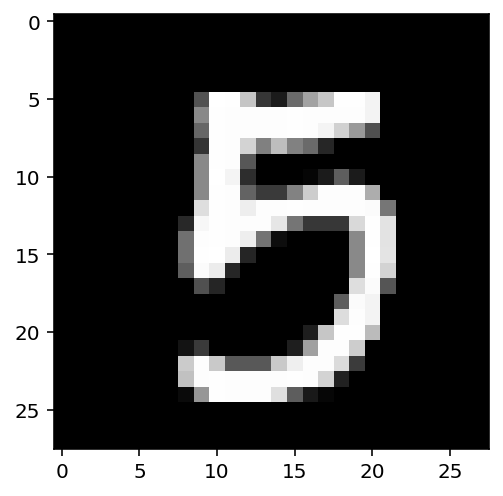

In [65]:
plt.imshow(images[1].numpy().squeeze(), cmap = 'Greys_r')

Now we want to build a multi layer network. The images are 28x28 2D tensors, we need so to convert them into 1D vectors. We need to convert the batch of images with shape (64,1,28,28) to have shape of (64,784), this operation is called flattening, we flattened the 2D images into 1D vectors.

In [66]:
inputs = images.view(images.shape[0], -1)
#Note that the -1 means 'flattening the others dimensions'
inputs.size()

torch.Size([64, 784])

#Let's build our network!
#Starting with the activation function
def sigmoid(x):
    return 1/(1 + torch.exp(-x))

#Create parameters!
nodes = 256
w1 = torch.randn(inputs.shape[1], nodes)
b1 = torch.randn(nodes)

#we want output to have dimension 10 as the number of digits

w2 = torch.randn(w1.shape[1], 10)
b2 = torch.randn(10)

h = sigmoid((torch.mm(inputs,w1)) + b1)

output = torch.mm(h, w2) + b2

In [70]:
def softmax(x):
    return torch.exp(x)/torch.sum(torch.exp(x), dim = 1).view(-1,1)
    

In [71]:
probabilities = softmax(output)
print(probabilities.shape)
# probabilities
#check if they are correct, the sum must return 1
print(probabilities.sum(dim = 1))

torch.Size([64, 10])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])


## Building networks with PyTorch

In [76]:
#PyTorch provides a module nn that makes building networks simpler

#subclassing nn.Module
class Network(torch.nn.Module):
    def __init__(self):
        #MANDATORY
        super().__init__() #allows inheritance of nn.Module
        
        #beginning layer
        #defines weights and bias automatically
        self.hidden = torch.nn.Linear(784, 256)
        #output layer
        self.output = torch.nn.Linear(256, 10)
        
        self.sigmoid = torch.nn.Sigmoid()
        self.softmax = torch.nn.Softmax(dim = 1)
        
    def forward(self, x):
        x = self.hidden(x)
        x = self.sigmoid(x)
        x = self.output(x)
        x = self.softmax(x)
        
        return x
        
        

In [77]:
model = Network()
model

Network(
  (hidden): Linear(in_features=784, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=1)
)

In [80]:
#More concisely through torch.nn.functional
import torch.nn.functional as F

class Network(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.hidden = torch.nn.Linear(784, 256)
        
        self.output = torch,nn.Linear(256,10)
        
    def forward(self, x):
        x = F.sigmoid(self.hidden(x))
        
        x = F.softmax(self.output(x), dim = 1)
        
        return x

In [82]:
#More concisely through torch.nn.functional
import torch.nn.functional as F

class Network(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.h1 = torch.nn.Linear(784, 256)
        
        self.h2 = torch.nn.Linear(256, 64)
        
        self.output = torch,nn.Linear(64,10)
        
    def forward(self, x):
        
        x = F.relu(self.h1(x)) #different activation function
        
        x = F.relu(self.h2(x))
        
        x = F.softmax(self.output(h2), dim = 1)
        
        return x

## Training neural networks

In [90]:
from torch import nn

model = nn.Sequential(nn.Linear(inputs.shape[1], 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64,10))

criterion = nn.CrossEntropyLoss()

logits = model(inputs)

loss = criterion(logits, labels)
print(loss)

tensor(2.3053, grad_fn=<NllLossBackward>)


In [93]:
from torch import nn

model = nn.Sequential(nn.Linear(inputs.shape[1], 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64,10),
                      nn.LogSoftmax(dim = 1))

criterion = nn.NLLLoss()

logprob = model(inputs)

loss = criterion(logprob, labels)
print(loss)

tensor(2.2957, grad_fn=<NllLossBackward>)


### Let's understand how we can compute the gradient 

In [94]:
x = torch.randn(2,2, requires_grad = True)
print(x)

tensor([[ 0.3519, -0.1708],
        [-0.0276,  0.4501]], requires_grad=True)


In [96]:
y = x **2 
print(y)

tensor([[0.1238, 0.0292],
        [0.0008, 0.2026]], grad_fn=<PowBackward0>)


In [97]:
print(y.grad_fn)

In [99]:
z = y.mean()
z

tensor(0.0891, grad_fn=<MeanBackward0>)

In [100]:
print(x.grad)

None


To calculate the gradient we need to run the ```.backward ``` method on a variable ``` z ```. This will calculate the gradient for ``` z ``` with respect to ``` x ```


In [101]:
z.backward()
print(x.grad)
print(x/2)

tensor([[ 0.1759, -0.0854],
        [-0.0138,  0.2250]])
tensor([[ 0.1759, -0.0854],
        [-0.0138,  0.2250]], grad_fn=<DivBackward0>)


### Loss and Autograd together

In [108]:
from torch import nn

model = nn.Sequential(nn.Linear(inputs.shape[1], 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64,10),
                      nn.LogSoftmax(dim = 1))

criterion = nn.NLLLoss()

logprob = model(inputs)

loss = criterion(logprob, labels)
print(loss)

tensor(2.3266, grad_fn=<NllLossBackward>)


In [109]:
print('Before bacward pass:\n', model[0].weight.grad)

loss.backward()

print('After bacward pass:\n', model[0].weight.grad)



Before bacward pass:
 None
After bacward pass:
 tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0038,  0.0038,  0.0038,  ...,  0.0038,  0.0038,  0.0038],
        [-0.0010, -0.0010, -0.0010,  ..., -0.0010, -0.0010, -0.0010],
        ...,
        [ 0.0026,  0.0026,  0.0026,  ...,  0.0026,  0.0026,  0.0026],
        [-0.0013, -0.0013, -0.0013,  ..., -0.0013, -0.0013, -0.0013],
        [ 0.0030,  0.0030,  0.0030,  ...,  0.0030,  0.0030,  0.0030]])


#### Now we have all the tools to train a network

In [111]:
from torch import optim

#To update the wights!

optimizer = optim.SGD(model.parameters(), lr = 0.01)

In [115]:
output = model.forward(inputs)

loss = criterion(output, labels)

loss.backward()

print('Gradient - ', model[0].weight.grad)

Gradient -  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0110,  0.0110,  0.0110,  ...,  0.0110,  0.0110,  0.0110],
        [-0.0029, -0.0029, -0.0029,  ..., -0.0029, -0.0029, -0.0029],
        ...,
        [ 0.0075,  0.0075,  0.0075,  ...,  0.0075,  0.0075,  0.0075],
        [-0.0031, -0.0031, -0.0031,  ..., -0.0031, -0.0031, -0.0031],
        [ 0.0092,  0.0092,  0.0092,  ...,  0.0092,  0.0092,  0.0092]])


In [117]:
w = model[0].weight

In [118]:
optimizer.step()
print('Updated weights - ', model[0].weight)

Updated weights -  Parameter containing:
tensor([[-0.0090, -0.0249, -0.0165,  ...,  0.0285,  0.0316, -0.0131],
        [ 0.0098,  0.0195,  0.0341,  ..., -0.0348,  0.0235, -0.0136],
        [ 0.0136,  0.0049, -0.0279,  ...,  0.0127,  0.0060, -0.0144],
        ...,
        [-0.0082,  0.0175, -0.0299,  ...,  0.0108,  0.0065, -0.0111],
        [-0.0277,  0.0337,  0.0303,  ...,  0.0153, -0.0189,  0.0118],
        [-0.0302,  0.0226, -0.0316,  ..., -0.0046, -0.0257, -0.0223]],
       requires_grad=True)


In [124]:
difference = w - 0.01*model[0].weight.grad # Step done by optimizer!

In [126]:
check = difference - model[0].weight
#Indeed, the difference is zero!

In [146]:
#Clear the gradients, do this because gadients are accumulated!!!

optimizer.zero_grad()

output = model.forward(inputs)

loss = criterion(output, labels)

loss.backward()

print('Gradient - ', model[0].weight)

optimizer.step()

Gradient -  Parameter containing:
tensor([[-0.0090, -0.0249, -0.0165,  ...,  0.0285,  0.0316, -0.0131],
        [ 0.0093,  0.0190,  0.0337,  ..., -0.0352,  0.0230, -0.0140],
        [ 0.0136,  0.0049, -0.0279,  ...,  0.0127,  0.0060, -0.0144],
        ...,
        [-0.0082,  0.0175, -0.0299,  ...,  0.0108,  0.0065, -0.0110],
        [-0.0279,  0.0335,  0.0301,  ...,  0.0151, -0.0191,  0.0116],
        [-0.0306,  0.0222, -0.0320,  ..., -0.0050, -0.0261, -0.0227]],
       requires_grad=True)


In [160]:
from torch import nn

model = nn.Sequential(nn.Linear(inputs.shape[1], 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64,10),
                      nn.LogSoftmax(dim = 1))

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.003)

epochs = 5

for e in range(epochs):
    
    print(e)
    running_loss = 0
    
    for images, labels in trainloader:
        images = images.view(images.shape[0], -1)

        optimizer.zero_grad()
        output = model.forward(images)
        loss = criterion(output, labels)        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    else:
        print(f"Training loss {running_loss/len(trainloader)}")
    



0
Training loss 1.8576685570196303
1
Training loss 0.793737343633607
2
Training loss 0.5083702960565909
3
Training loss 0.42508536975965827
4
Training loss 0.38547872114918635


In [163]:
%matplotlib inline

import helpML

images, labels = next(iter(trainloader))

img = images[0].view(1, 784)

with torch.no_grad():
    logits = model.forward(img)
    
ps = F.softmax(logits, dim = 1)
helper.view_classify(img.view(1,28,28), ps)

AttributeError: module 'helper' has no attribute 'view_classify'

helpML.py  MNIST_data  __pycache__  PyTorch_Introduction.ipynb	Untitled.ipynb
